# Анализ рынка в сфере общественного питания Москвы

**Цель проекта:**
Перед открытием небольшого кафе с уникальным предложением - роботы-официанты - проанализировать текущее положение дел на рынке, для определения
- перспективного вида заведения,
- оптимального количества посадочных мест,
- района расположения.

**Задачи:**
- исследовать соотношение видов объектов общественного питания по количеству
- исследовать соотношение сетевых и несетевых заведений по количеству, определить для какого вида объекта общественного питания характерно сетевое распространение, а также что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест? 
- для каждого вида объекта общественного питания описать среднее количество посадочных мест, определить какой вид предоставляет в среднем самое большое количество посадочных мест 
-  найти топ-10 улиц по количеству объектов общественного питания, а также назвать в каких районах Москвы находятся эти улицы
- найти число улиц с одним объектом общественного питания, определить в каких районах Москвы находятся эти улицы



**Описание данных:**

Таблица rest_data:

- id — идентификатор объекта;
- object_name — название объекта общественного питания;
- chain — сетевой ресторан;
- object_type — тип объекта общественного питания;
- address — адрес;
- number — количество посадочных мест.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

from io import BytesIO
import requests

In [2]:
data_eat = pd.read_csv('')

## Знакомство с данными

In [3]:
data_eat.head(10)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


In [4]:
data_eat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [5]:
# проверяем на дубликаты, исключив ID
data = data_eat[['object_name', 'chain', 'object_type', 'address', 'number']]
data.duplicated().sum(), data.duplicated().sum()/len(data)


(82, 0.005336457113106859)

In [6]:
# дублей меньше 1 %, удалим
data = data.drop_duplicates()
len(data)

15284

In [7]:
# вернем id
data['id'] = data_eat['id']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15284 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   object_name  15284 non-null  object
 1   chain        15284 non-null  object
 2   object_type  15284 non-null  object
 3   address      15284 non-null  object
 4   number       15284 non-null  int64 
 5   id           15284 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 835.8+ KB


In [8]:
data.head()

,object_name,chain,object_type,address,number,id
0,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,151635
1,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,77874
2,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,24309
3,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,21894
4,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,119365


В таблице пропусков нет, были найдены 82 явных дубликата (доля - менее 1 %) - они были удалены. Большинство столбцов с типом данных object (посмотрим можно ли проверить на неявные дубли), в строках используется разный регистр - для удобства приведем к нижнему. Названия столбцов понятные, исправлять написание так же не нужно.

In [9]:
# приводим к нижнему регистру
data['object_name'] = data['object_name'].str.lower()
data['address'] = data['address'].str.lower()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15284 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   object_name  15284 non-null  object
 1   chain        15284 non-null  object
 2   object_type  15284 non-null  object
 3   address      15284 non-null  object
 4   number       15284 non-null  int64 
 5   id           15284 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 835.8+ KB


Видим, что из-за регистра дубликатов не было.

In [11]:
# посмотрим значения 
data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

In [12]:
# посмотрим значения
data['chain'].unique()

array(['нет', 'да'], dtype=object)

В столбцах 'object_type', 'chain' неявных дубликатов также нет

### Вывод

Явные дубликаты (доля менее 1%) - удалены, пропусков нет. Были приведены к нижнему регистру столбцы object_name и address, удаления данных не было.

## Соотношение видов объектов общественного питания по количеству

In [13]:
object_type_count = data.groupby('object_type')['id'].count().sort_values(ascending = False)
object_type_count

object_type
кафе                                 6071
столовая                             2584
ресторан                             2282
предприятие быстрого обслуживания    1898
бар                                   855
буфет                                 577
кафетерий                             395
закусочная                            349
магазин (отдел кулинарии)             273
Name: id, dtype: int64

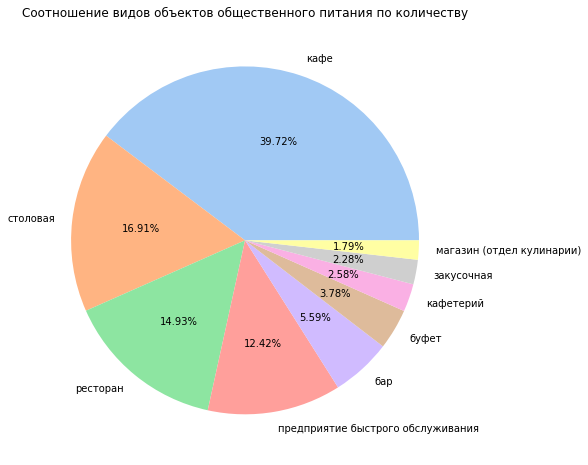

In [14]:
# строим круговую диаграмму
colors = sns.color_palette('pastel')

object_type_count.plot(
    kind='pie', y = 'id', colors = colors, autopct='%.2f%%', figsize = (15,8)
)
plt.ylabel('')
plt.title('Соотношение видов объектов общественного питания по количеству')
plt.show()

**Топ-5 заведений по типу:**
- кафе 39.72%
- столовая 16.91%
- ресторан 14.93%
- предприятие быстрого обслуживания 12.42%
- бар 5.59%

Остальные - суммарно занимают 10.43%

## Сетевые заведения

### Cоотношение сетевых и несетевых заведений по количеству

In [15]:
# посчитаем количество
chain_count = data.groupby('chain')['id'].count()
chain_count

chain
да      2964
нет    12320
Name: id, dtype: int64

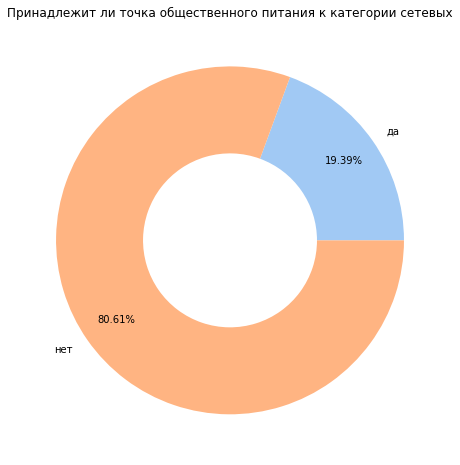

In [16]:
# построим диаграмму
chain_count.plot(
    kind='pie', y = 'id', colors = colors, autopct='%.2f%%', figsize = (15,8),wedgeprops=dict(width=0.5), pctdistance=0.8
)
plt.ylabel('')
plt.title('Принадлежит ли точка общественного питания к категории сетевых')
plt.show()

**В Москве преобладают несетевые заведения, их доля - 80.61%**

### Распределение типов заведений внутри сетевых/не сетевых

In [17]:
# подготовим сводную таблицу
chain_pivot_table = data.pivot_table(index='object_type', columns='chain', values='id', aggfunc='count')
chain_pivot_table = chain_pivot_table.rename(columns={'да':'сетевое', 'нет':'не сетевое'}).sort_values(by = 'не сетевое')
chain_pivot_table

chain,сетевое,не сетевое
object_type,,
магазин (отдел кулинарии),78,195
закусочная,56,293
кафетерий,52,343
буфет,11,566
бар,37,818
предприятие быстрого обслуживания,788,1110
ресторан,543,1739
столовая,3,2581
кафе,1396,4675


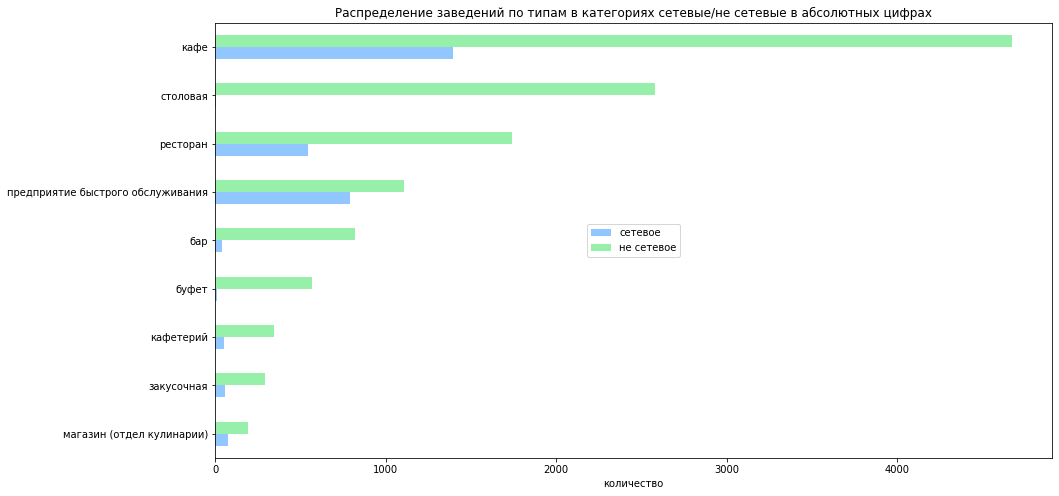

In [18]:
# построим график
with plt.style.context('seaborn-pastel'):
    chain_pivot_table.plot(kind='barh', figsize = (15,8))
plt.title('Распределение заведений по типам в категориях сетевые/не сетевые в абсолютных цифрах')
plt.ylabel('')
plt.xlabel('количество')
plt.legend(loc=10)
plt.show()

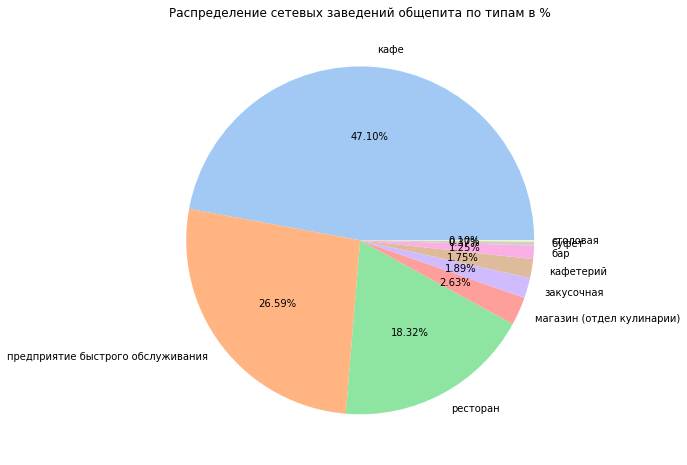

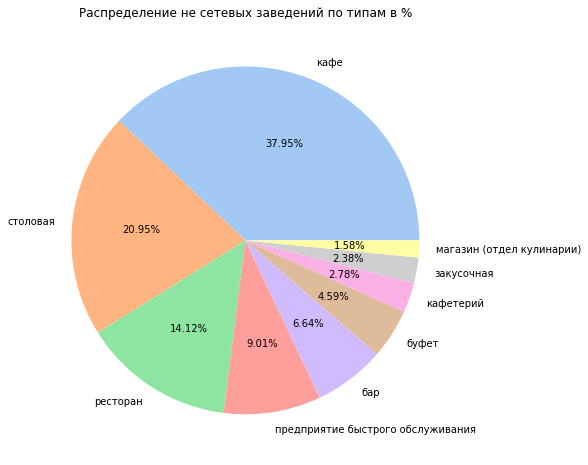

In [19]:
chain_pivot_table.sort_values(by='сетевое', ascending=False).plot(
    kind='pie', y = 'сетевое', colors = colors, autopct='%.2f%%',
    figsize = (15,8), pctdistance=0.6, legend=False
)
plt.ylabel('')
plt.title('Распределение сетевых заведений общепита по типам в %')

chain_pivot_table.sort_values(by='не сетевое', ascending=False).plot(
    kind='pie', y = 'не сетевое', colors = colors, autopct='%.2f%%',
    figsize = (15,8), pctdistance=0.6, legend=False
)
plt.ylabel('')
plt.title('Распределение не сетевых заведений по типам в %')


plt.show()

- кафе самый популярный тип заведения для двух категорий
- далее в категории "сетевые" более популярны предприятия быстрого обслуживания, рестораны
- для категории "не сетевые" на втором месте по популярности идут столовые, далее рестораны и предприятия быстрого обслуживания

### Оценка распределения количества мест

Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [20]:
# выделим сетевые заведения в отдельный df
chain_data = data[data['chain'] == 'да']

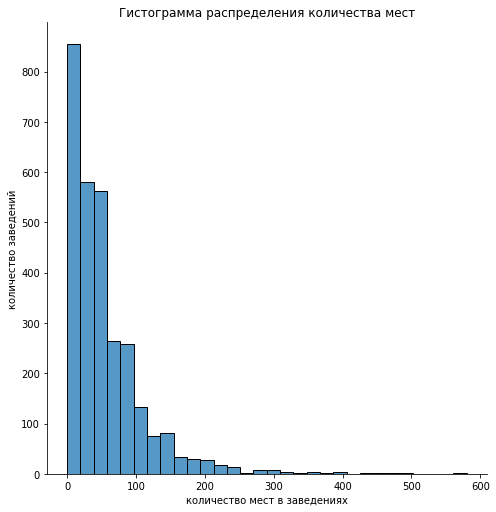

In [21]:
# построим гистограмму
sns.displot(chain_data['number'], bins = 30, height = 7)
plt.title('Гистограмма распределения количества мест')
plt.ylabel('количество заведений')
plt.xlabel('количество мест в заведениях')
plt.show()


Много заведений до 100 посадочных мест, среди них преобладают заведения до 0-20 посадочных мест.

Далее посмотрим распределение мест по типам заведений.

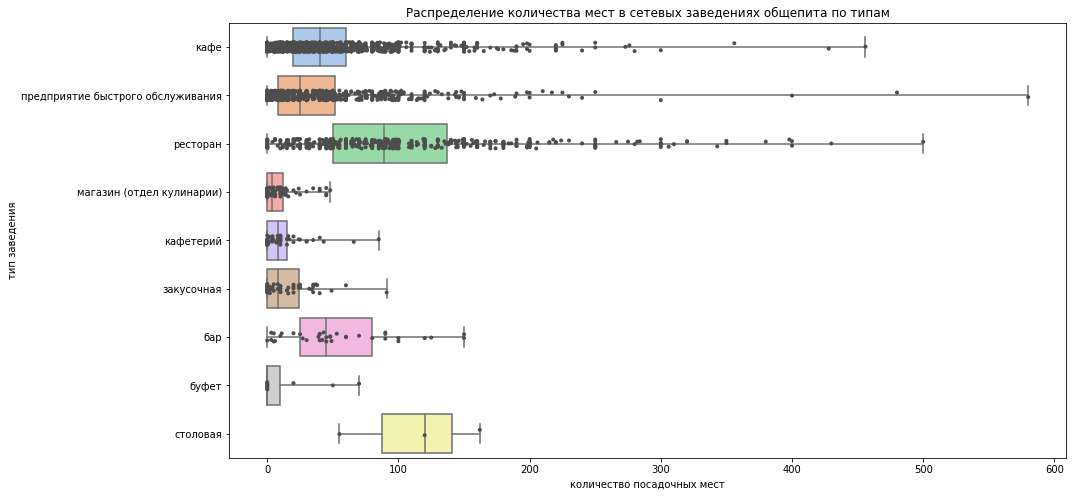

In [22]:
# построим боксплоты с наглядным распределением значений
f, ax = plt.subplots(figsize=(15,8 ))

sns.boxplot(x="number" , y = "object_type" , data = chain_data, whis = [ 0 ,100], palette = 'pastel')

sns.stripplot(x="number" , y = "object_type" , data = chain_data, size = 4 , color = ".3" , linewidth = 0) 

plt.title('Распределение количества мест в сетевых заведениях общепита по типам')
plt.xlabel('количество посадочных мест')
plt.ylabel('тип заведения')
plt.show()


**Для сетевых заведений Москвы характерно-  много заведений с небольшим количеством посадочных мест**

In [23]:
# сгруппируем сетевые заведение по имени и посмотрим количество заведений в сети и среднее количество посадочных мест в них
chain_info = chain_data.groupby(['object_name']).agg({'id':'count', 'number':'mean', })
chain_info = chain_info.rename(columns={'id':'count', 'number':'number_mean'})
chain_info.head()

,count,number_mean
object_name,,
beverly hills diner,1,88.000000
bierloga,1,75.000000
black & white,1,40.000000
bocconcino,3,66.666667
boobo,1,46.000000


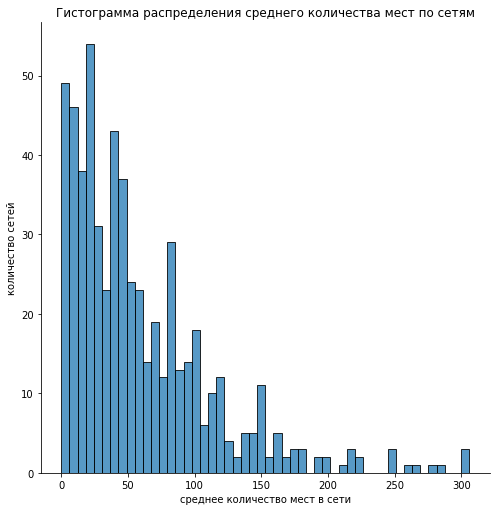

In [24]:
# построим график
sns.displot(chain_info ['number_mean'], bins = 50, height = 7)
plt.title('Гистограмма распределения среднего количества мест по сетям')
plt.ylabel('количество сетей')
plt.xlabel('среднее количество мест в сети')

plt.show()


Тренд виден - в большом количестве сетей среднее количество посадочных мест до 50.

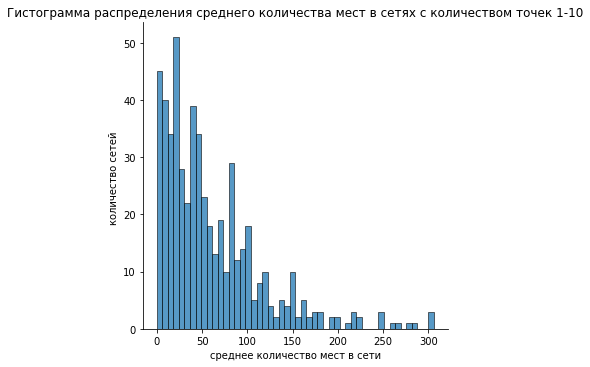

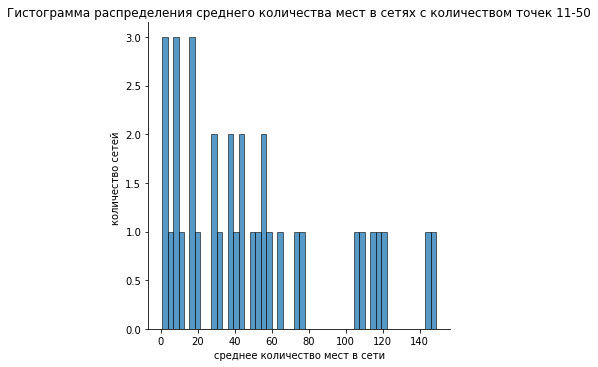

In [25]:
# посмотрим небольшие сети - до 10 точек
sns.displot(chain_info.query('count <= 10')['number_mean'], bins = 50, height = 5)
plt.title('Гистограмма распределения среднего количества мест в сетях с количеством точек 1-10')
plt.ylabel('количество сетей ')
plt.xlabel('среднее количество мест в сети')

sns.displot(chain_info.query('10 < count <= 50')['number_mean'], bins = 50, height = 5)
plt.title('Гистограмма распределения среднего количества мест в сетях с количеством точек 11-50')
plt.ylabel('количество сетей ')
plt.xlabel('среднее количество мест в сети')

plt.show()


**Чем больше в сети точек, тем меньше в точках этой сети посадочных мест**

## Количество посадочных мест

- Для каждого вида объекта общественного питания опишем среднее количество посадочных мест.
- Определим какой вид предоставляет в среднем самое большое количество посадочных мест.

In [26]:
# сгруппируем и посчитаем среднее
number = data.groupby('object_type')['number'].mean().sort_values(ascending=False)
number

object_type
столовая                             130.337848
ресторан                              96.884750
буфет                                 51.509532
бар                                   43.533333
кафе                                  39.785703
предприятие быстрого обслуживания     20.808219
кафетерий                              9.184810
закусочная                             7.825215
магазин (отдел кулинарии)              5.589744
Name: number, dtype: float64

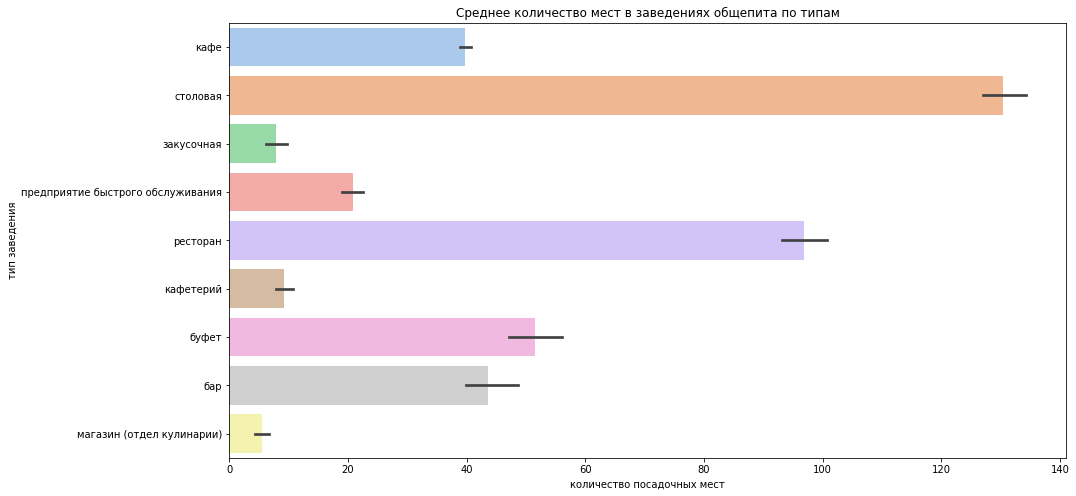

In [27]:
# построим график
f, ax = plt.subplots(figsize=(15,8 ))
sns.barplot(y='object_type', x='number', data=data, palette='pastel')
plt.title('Среднее количество мест в заведениях общепита по типам')
plt.xlabel('количество посадочных мест')
plt.ylabel('тип заведения')
plt.show()

**По среднему количеству мест  с большим отрывом лидируют столовые (130 мест) и рестораны (96 мест). Самый популярный тип заведений общепита - кафе - по среднему количеству посадочных мест (39) уступает и буфетам (51), и барам(43).**

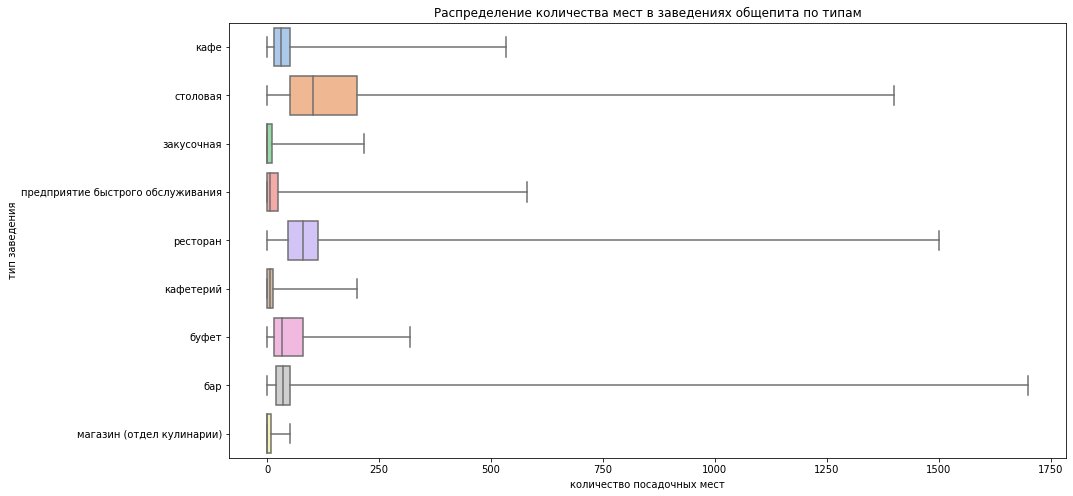

In [28]:
f, ax = plt.subplots(figsize=(15,8 ))

sns.boxplot(x="number" , y = "object_type" , data = data, whis = [ 0 ,100], palette = 'pastel')

plt.title('Распределение количества мест в заведениях общепита по типам')
plt.xlabel('количество посадочных мест')
plt.ylabel('тип заведения')
plt.show()

## Обогащаем данные, для дальнейшего анализа

- Выделим в отдельный столбец информацию об улице из столбца address
- Импортируем из открытых данных таблицу с более полными данными по заведениям общепита Москвы (с указанием районов, и географических координат)

In [29]:
# Выделим в отдельный столбец информацию об улице из столбца address 
data['street'] = data['address'].map(lambda x: x.split(','))
data['street'] = data['street'].map(lambda x: x[1])
data.head()

,object_name,chain,object_type,address,number,id,street
0,сметана,нет,кафе,"город москва, улица егора абакумова, дом 9",48,151635,улица егора абакумова
1,родник,нет,кафе,"город москва, улица талалихина, дом 2/1, корпус 1",35,77874,улица талалихина
2,кафе «академия»,нет,кафе,"город москва, абельмановская улица, дом 6",95,24309,абельмановская улица
3,пиццетория,да,кафе,"город москва, абрамцевская улица, дом 1",40,21894,абрамцевская улица
4,кафе «вишневая метель»,нет,кафе,"город москва, абрамцевская улица, дом 9, корпус 1",50,119365,абрамцевская улица


In [30]:
# получаем файл, смотрим его структуру
spreadsheet_id = '1MPQi9VSKSTzbSCCgTQC1SZS4TmTKp4jufhGnEdM_u-M'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18766 entries, 0 to 18765
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   18766 non-null  object
 1   Name                 18766 non-null  object
 2   global_id            18766 non-null  object
 3   IsNetObject          18766 non-null  object
 4   OperatingCompany     3592 non-null   object
 5   TypeObject           18766 non-null  object
 6   AdmArea              18766 non-null  object
 7   District             18766 non-null  object
 8   Address              18766 non-null  object
 9   PublicPhone          18766 non-null  object
 10  SeatsCount           18766 non-null  object
 11  SocialPrivileges     18766 non-null  object
 12  Longitude_WGS84      18766 non-null  object
 13  Latitude_WGS84       18766 non-null  object
 14  ID_en                1 non-null      object
 15  Name_en              1 non-null      object
 16  IsNe

In [31]:
# оставляем нужные столбцы
data_rest = df[['ID', 'District', 'Longitude_WGS84', 'Latitude_WGS84']] 
# убираем строку с индексом 0, дублирующую названия столбцов
data_rest = data_rest.drop(labels = [0], axis = 0)
# приводим к нужным типам данных
data_rest['ID'] = pd.to_numeric(data_rest['ID'])
data_rest['Longitude_WGS84'] = pd.to_numeric(data_rest['Longitude_WGS84'])
data_rest['Latitude_WGS84'] = pd.to_numeric(data_rest['Latitude_WGS84'])
# переименовываем столбец для дальнейшего объединения таблиц
data_rest = data_rest.rename(columns={'ID':'id'})

In [32]:
data_rest.head()

,id,District,Longitude_WGS84,Latitude_WGS84
1,151635,Ярославский район,37.714565,55.879002
2,77874,Таганский район,37.673306,55.738239
3,24309,Таганский район,37.669648,55.735511
4,27429,район Лианозово,37.566940,55.904019
5,148815,район Арбат,37.598128,55.747390


In [33]:
# объединяем таблицы
rest_total = pd.merge(data, data_rest, on = 'id', how='left')
rest_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15284 entries, 0 to 15283
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   object_name      15284 non-null  object 
 1   chain            15284 non-null  object 
 2   object_type      15284 non-null  object 
 3   address          15284 non-null  object 
 4   number           15284 non-null  int64  
 5   id               15284 non-null  int64  
 6   street           15284 non-null  object 
 7   District         7914 non-null   object 
 8   Longitude_WGS84  7914 non-null   float64
 9   Latitude_WGS84   7914 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 1.3+ MB


**В таблице с доп.данными количество строк больше, чем в исходном датафрейме. При объединении мы "сознательно потеряли" часть данных из доп.таблицы, в столбцах с координатами и с районами - пропуски около 50% от всех данных.**

## Топ-10 улиц по количеству объектов общественного питания

- Выдели топ-10 улиц по количеству объектов общественного питания.
- Ответим на вопрос — в каких районах Москвы находятся эти улицы?

In [34]:
# сгруппируем данные и найдем топ-10
top_much = rest_total.groupby('street').agg({'object_name':'count'}).rename(
    columns={'object_name':'count_name'}
).sort_values(by='count_name', ascending=False).reset_index()
print(top_much[0:10])

                    street  count_name
0         город зеленоград         232
1            проспект мира         204
2        профсоюзная улица         181
3   ленинградский проспект         170
4   пресненская набережная         167
5         варшавское шоссе         161
6       ленинский проспект         147
7      поселение сосенское         137
8     проспект вернадского         128
9     кутузовский проспект         114


In [35]:
# посчитаем долю строк с Зеленоградом
232/len(data)*100

1.5179272441769172

Город Зеленоград - один из административных округов Москвы с экспериментальной планировкой, в нем нет улиц.

https://www.zelenograd.ru/gid/kak-ustroen-zelenograd/

Данных с Зеленоградом немного (их доля в общей массе 1.5%), разделять данные по районам или микрорайонам  и оставлять в данных - некорректный подход, а составлять из номеров домов "улицы" займет большое количество времени, поэтому исключим Зеленоград из нашего топ-10. Но на будущее заметим, что этот округ можно подробнее посмотреть на месте.

In [36]:
# топ-10 без Зеленограда
much_name_data =  top_much[1:11]
much_name_data 

,street,count_name
1,проспект мира,204
2,профсоюзная улица,181
3,ленинградский проспект,170
4,пресненская набережная,167
5,варшавское шоссе,161
6,ленинский проспект,147
7,поселение сосенское,137
8,проспект вернадского,128
9,кутузовский проспект,114
10,каширское шоссе,111


Далее найдем районы, в которых расположены эти улицы.

In [38]:
# получаем список улиц
list_much_name_data = list(much_name_data ['street'])

In [39]:
# перезаписываем сборный датафрейм, оставляя только нужные улицы
top_much_data = rest_total[rest_total['street'].isin(list_much_name_data)]
# смотрим как распределились значения
top_much_data['District'].value_counts()

Пресненский район                  74
поселение Сосенское                51
район Тропарёво-Никулино           48
Мещанский район                    40
район Аэропорт                     39
Обручевский район                  36
район Беговой                      33
район Дорогомилово                 27
Алексеевский район                 23
Нагорный район                     21
Гагаринский район                  21
район Чертаново Южное              21
Донской район                      20
район Москворечье-Сабурово         19
район Коньково                     19
Ломоносовский район                18
район Нагатино-Садовники           16
район Сокол                        16
район Черёмушки                    16
район Тёплый Стан                  14
район Раменки                      12
район Фили-Давыдково               12
поселение Краснопахорское          11
Академический район                10
район Проспект Вернадского         10
район Якиманка                      9
Останкинский

In [40]:
# визуализируем на карте Москвы распределение заведений по популярным улицам, там же можно увидеть районы
figure = px.scatter_mapbox(
    top_much_data.loc[top_much_data['Longitude_WGS84'].notna()],
    lat = 'Latitude_WGS84', lon = 'Longitude_WGS84', color='street',
    color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=9,
    center={'lat':55.71, 'lon': 37.61},
    mapbox_style='carto-positron', title = 'Улицы и районы с самым большим количеством заведений общепита'   
)
figure.show()

- БОльшее количество улиц со скоплением заведений общественного питания расположены на юге и юго-западе столицы. На севере таких улиц меньше, на востоке практически нет.
- Точки заведений распределяются предсказуемыми "лучами: много заведений по крупным автодорогам от центра до МКАДа (на юге и юго-западе), на севере столицы границы скопления заведений общепита заканчиваются раньше - примерно на Северо-восточной хорде/Алабяно-Балтийском тоннеле.
- за МКАДом выделяется поселение Сосненское

## Улицы с одним объектом общественного питания

- Найдем число улиц с одним объектом общественного питания.
- Посмотрим по внешним данным в каких районах Москвы находятся эти улицы?

In [41]:
# из предыдущей группировки найдем число таких улиц и их долю
one_name = top_much.loc[top_much['count_name'] == 1]
len(one_name), len(one_name)/len(top_much)*100

(579, 30.473684210526315)

In [42]:
# перенесем их в список
one_list = list(one_name['street'])

In [43]:
rest = rest_total[rest_total['street'].isin(one_list)]
len(rest)

579

In [44]:
rest['District'].isna().sum()

232

In [45]:
rest['District'].value_counts()[:10]

Таганский район       24
Пресненский район     16
Тверской район        16
Басманный район       14
район Хамовники       13
район Сокольники      11
район Южное Бутово    10
Можайский район        8
Мещанский район        8
район Богородское      8
Name: District, dtype: int64

In [46]:
figure = px.scatter_mapbox(
    rest.loc[rest['Longitude_WGS84'].notna()],
    lat = 'Latitude_WGS84', lon = 'Longitude_WGS84', color='street',
    color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=8,
    center={'lat':55.71, 'lon': 37.61},
    mapbox_style='carto-positron', title = 'Улицы и районы с одним заведением общепита'   
)
figure.show()

- В тех же границах - внутри МКАДа расположено большинство улиц с "уникальным" заведением общепита
- Большинство точек расположены ближе к центру города
- По направлениям - чуть больше точек на севере столицы

## Вывод

Перед открытием небольшого кафе мы проанализировали текущее положение дел на рынке и сделали следующие выводы:
- В Москве преобладают несетевые заведения.
- Кафе - самый популярный тип заведения. В категории "сетевые" - кроме кафе популярны предприятия быстрого обслуживания и рестораны, для категории "не сетевые" кроме кафе популярны - столовые, рестораны и предприятия быстрого обслуживания.
- По среднему количеству мест с большим отрывом лидируют столовые и рестораны. Кафе - по среднему количеству посадочных мест  уступает и буфетам, и барам.
- География. Есть популярные улицы, на которых много заведений общепита, но также есть улицы всего с одним заведением и такие улицы можно найти и в центре столицы, и в более отдаленных районах.

Рекомендации:
- Перспективными для нашего проекта можем назвать кафе, предприятия быстрого обслуживания, возможно, бар (если есть перспектива на сетевой тип предприятия - оптимальнее кафе и предприятие быстрого обслуживания).
- Мы планируем открыть заведение на небольшое количество посадочных мест, поэтому предпочтительнее также формат кафе или предприятия быстрого обслуживания (возможен вариант и с баром - барменов-роботов нужно меньше, чем официантов, и запуск проекта, возможно, обойдется дешевле).
- Географичесий выбор - не рекомендуем рассматривать восточные районы. Рядом с центрами притяжения (улицами с большим количеством точек общественного питания) есть достаточно много небольших улиц, где присутствует только одна точка общепита.Если мы ориентированы на массового покупателя без точечного выделения целевой аудитории - следует выбрать центральный район города, место проходимое туристами, возможно, недалеко от метро.